# Data

In [163]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import yfinance as yf
from pandas_datareader import data as pdr
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objs as go

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate,LeakyReLU

np.random.seed(10)
pd.set_option('display.max_columns', None)
yf.pdr_override()
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

#Alpha vantage

2OQT6WT9WH45WTK5

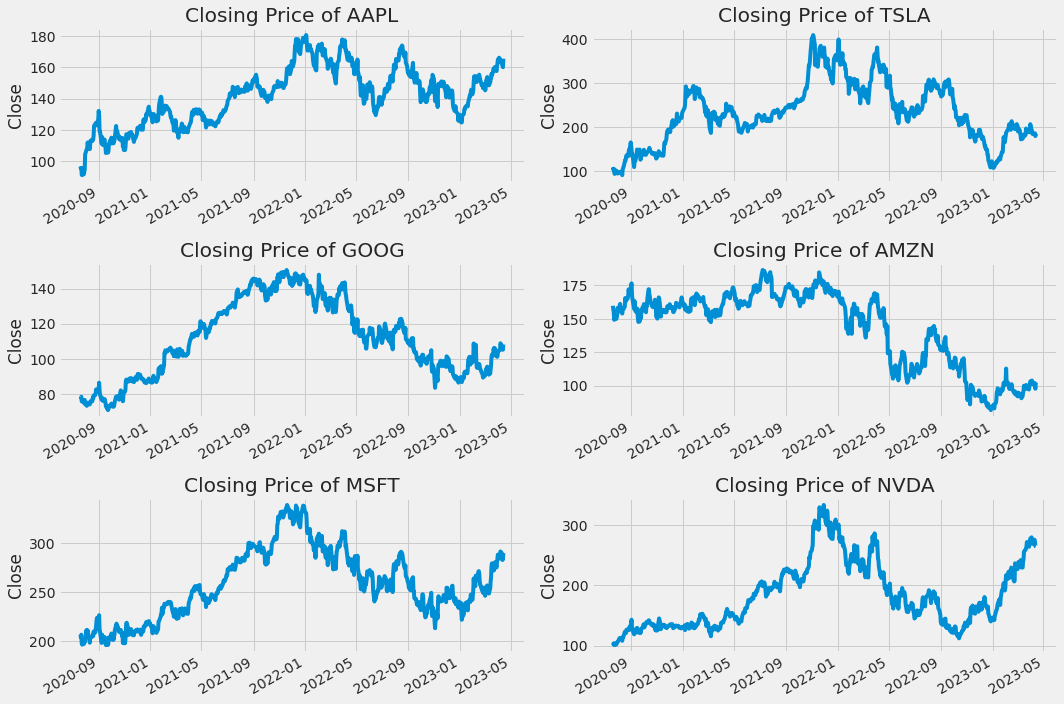

In [14]:
tech_list = ["AAPL",
            "TSLA",
            "GOOG",
            "AMZN",
            "MSFT",
            "NVDA"]
Starting = "2020-07-20"
Ending = "2023-04-14"

tickers = yf.Tickers(tech_list)
for company in tech_list:
    globals()[company] = tickers.tickers[company].history(start=Starting,end=Ending)

company_list = [AAPL,
            TSLA,
            GOOG,
            AMZN,
            MSFT,
            NVDA]
company_name = ["AAPL",
            "TSLA",
            "GOOG",
            "AMZN",
            "MSFT",
            "NVDA"]
for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)
for i, company in enumerate(company_list, 1):
    plt.subplot(3, 2, i)
    company['Close'].plot()
    plt.ylabel('Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {tech_list[i - 1]}")
    
plt.tight_layout()

[*********************100%***********************]  6 of 6 completed


Text(0.5, 1.0, 'Correlation of stock closing price')

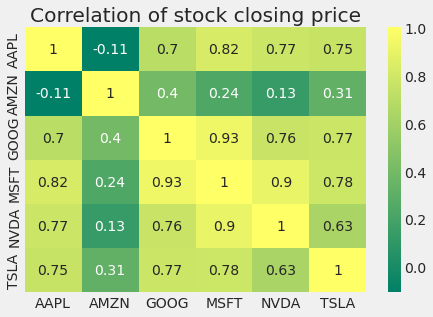

In [29]:
closing_df = pdr.get_data_yahoo(tech_list, start=Starting, end=Ending)['Close']
closing_df
# Make a new tech returns DataFrame
tech_rets = closing_df.pct_change()
tech_rets.head()

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 2)
sns.heatmap(closing_df.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock closing price')

In [30]:
#df = yf.download(tickers = 'TSLA', start = '2022-03-11',end = '2023-03-11')
company = "TSLA"
Starting = "2020-07-20"
Ending = "2023-04-14"

tickers = yf.Tickers(company)
StockPrice = tickers.tickers[company].history(start=Starting,end=Ending)
StockPrice.index = pd.to_datetime(StockPrice.index).date

Path = f"../Part3_FinBert/output/predictions_{company}.csv"
Sentiment = pd.read_csv(Path).iloc[::-1]\
                            .reset_index()\
                            .drop(['Unnamed: 0', "index"],axis=1)

Sentiment = Sentiment[Sentiment["date"] >= Starting]
Sentiment['date'] = pd.to_datetime(Sentiment['date'])
Sentiment.set_index('date', inplace=True)
Sentiment.index = pd.to_datetime(Sentiment.index).date
Sentiment

,score_title,score_summary
2020-07-20,0.108546,-0.013208
2020-07-21,-0.150379,-0.009721
2020-07-22,-0.147650,0.057897
2020-07-23,0.028656,0.034656
2020-07-24,-0.264506,-0.091593
...,...,...
2023-04-13,0.045576,0.059780
2023-04-14,-0.117404,-0.210186
2023-04-15,-0.094414,-0.103239
2023-04-16,-0.055805,0.140749


In [31]:
missing_rows_index = StockPrice.index.difference(Sentiment.index)
new_data = {'score_title': 0, 'score_summary': 0}
new_row = pd.DataFrame(new_data, index=missing_rows_index)
Sentiment = pd.concat((new_row,Sentiment),axis=0,sort=False)
index_to_keep = pd.Series(True, index=StockPrice.index)
mask = Sentiment.index.isin(index_to_keep.index)
Sentiment = Sentiment[mask]
Full_data = pd.concat((StockPrice,Sentiment),axis=1)
Full_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,score_title,score_summary
2020-07-20,101.267334,110.000000,99.199997,109.533333,256821000,0.0,0.0,0.108546,-0.013208
2020-07-21,109.328667,111.666664,103.866669,104.557335,241608000,0.0,0.0,-0.150379,-0.009721
2020-07-22,106.599998,108.428001,104.133331,106.155334,212416500,0.0,0.0,-0.147650,0.057897
2020-07-23,111.930000,112.599998,98.718002,100.871330,364927500,0.0,0.0,0.028656,0.034656
2020-07-24,94.400665,97.666664,91.102669,94.466667,290949000,0.0,0.0,-0.264506,-0.091593
...,...,...,...,...,...,...,...,...,...
2023-04-06,183.080002,186.389999,179.740005,185.059998,123857900,0.0,0.0,-0.080997,0.019024
2023-04-10,179.940002,185.100006,176.110001,184.509995,142154600,0.0,0.0,-0.066649,-0.001051
2023-04-11,186.690002,189.190002,185.649994,186.789993,115770900,0.0,0.0,-0.112037,-0.080313
2023-04-12,190.740005,191.580002,180.309998,180.539993,150256300,0.0,0.0,0.051657,0.028311


In [32]:
Full_data['RSI']=ta.rsi(Full_data.Close, length=30)
Full_data['EMA']=ta.ema(Full_data.Close, length=30)


#Full_data['Target'] = Full_data['Close']-Full_data.Open
#Full_data['Target'] = Full_data['Target'].shift(-1)
#Full_data['TargetClass'] = [1 if Full_data.Target[i]>0 else 0 for i in range(len(Full_data))]

Full_data['TargetNextClose'] = Full_data['Close'].shift(-1)
Full_data['TargetNextClose'] = Full_data['Close'].shift(-1)
Full_data
Full_data.iloc[:, 0:-1].dropna(inplace=True)
#Full_data.reset_index(inplace = True)
Full_data.drop(['Volume'], axis=1, inplace=True)
Full_data

,Open,High,Low,Close,Dividends,Stock Splits,score_title,score_summary,RSI,EMA,TargetNextClose
2020-07-20,101.267334,110.000000,99.199997,109.533333,0.0,0.0,0.108546,-0.013208,NaN,NaN,104.557335
2020-07-21,109.328667,111.666664,103.866669,104.557335,0.0,0.0,-0.150379,-0.009721,NaN,NaN,106.155334
2020-07-22,106.599998,108.428001,104.133331,106.155334,0.0,0.0,-0.147650,0.057897,NaN,NaN,100.871330
2020-07-23,111.930000,112.599998,98.718002,100.871330,0.0,0.0,0.028656,0.034656,NaN,NaN,94.466667
2020-07-24,94.400665,97.666664,91.102669,94.466667,0.0,0.0,-0.264506,-0.091593,NaN,NaN,102.639999
...,...,...,...,...,...,...,...,...,...,...,...
2023-04-06,183.080002,186.389999,179.740005,185.059998,0.0,0.0,-0.080997,0.019024,49.882707,189.078367,184.509995
2023-04-10,179.940002,185.100006,176.110001,184.509995,0.0,0.0,-0.066649,-0.001051,49.712360,188.783633,186.789993
2023-04-11,186.690002,189.190002,185.649994,186.789993,0.0,0.0,-0.112037,-0.080313,50.438172,188.655011,180.539993
2023-04-12,190.740005,191.580002,180.309998,180.539993,0.0,0.0,0.051657,0.028311,48.454957,188.131462,185.899994


In [33]:
data_set = Full_data.iloc[30:-1, 6:14]
data_set

,score_title,score_summary,RSI,EMA,TargetNextClose
2020-08-31,0.064944,0.178783,78.587101,115.660970,158.350006
2020-09-01,0.139595,0.208545,72.223916,118.415101,149.123337
2020-09-02,-0.175306,0.031887,65.679839,120.396277,135.666672
2020-09-03,-0.072719,-0.187810,57.780923,121.381464,139.440002
2020-09-04,-0.066646,-0.387875,59.204111,122.546531,110.070000
...,...,...,...,...,...
2023-04-05,0.159216,0.101471,50.021287,189.355496,185.059998
2023-04-06,-0.080997,0.019024,49.882707,189.078367,184.509995
2023-04-10,-0.066649,-0.001051,49.712360,188.783633,186.789993
2023-04-11,-0.112037,-0.080313,50.438172,188.655011,180.539993


In [37]:
sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(data_set)
print(data_set_scaled.shape, data_set.columns.shape,data_set.index.shape)
df = pd.DataFrame(data_set_scaled, columns=data_set.columns, index=data_set.index)
df

(658, 5) (5,) (658,)


,score_title,score_summary,RSI,EMA,TargetNextClose
2020-08-31,0.568099,0.671994,0.872132,0.000000,0.166462
2020-09-01,0.611594,0.690165,0.763835,0.011589,0.135897
2020-09-02,0.428118,0.582304,0.652460,0.019925,0.091320
2020-09-03,0.487890,0.448165,0.518026,0.024070,0.103820
2020-09-04,0.491428,0.326013,0.542247,0.028972,0.006526
...,...,...,...,...,...
2023-04-05,0.623026,0.624790,0.385962,0.310083,0.254944
2023-04-06,0.483067,0.574451,0.383604,0.308917,0.253122
2023-04-10,0.491427,0.562193,0.380705,0.307677,0.260675
2023-04-11,0.464982,0.513799,0.393057,0.307136,0.239971


In [38]:
# multiple feature from data provided to the model
X = []
backcandles = 10 # Look back period

print(data_set_scaled.shape[0])
for j in range(4):
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):
        X[j].append(data_set_scaled[i-backcandles:i, j])

#move axis from 0 to position 2
X=np.moveaxis(X, [0], [2])

X, yi =np.array(X), np.array(data_set_scaled[backcandles:,-1])
y=np.reshape(yi,(len(yi),1))

print("Shape of X:",X.shape) #658 data, 10 days loop back, 6 indicators
print("Shape of y:",y.shape) #Start from 10 days since need 10 to process data

df = pd.DataFrame(y, columns=["Target"], index=df.index[backcandles:])
df

658
Shape of X: (648, 10, 4)
Shape of y: (648, 1)


,Target
2020-09-15,0.129703
2020-09-16,0.109462
2020-09-17,0.130133
2020-09-18,0.138128
2020-09-21,0.110346
...,...
2023-04-05,0.254944
2023-04-06,0.253122
2023-04-10,0.260675
2023-04-11,0.239971


In [39]:
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

518
(518, 10, 4)
(130, 10, 4)
(518, 1)
(130, 1)


# Model Training

In [71]:
def plot_result():
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df.index, y=y_test.ravel(), name='original', line=dict(color='green')))
    fig.add_trace(go.Scatter(x=df.index, y=y_pred.ravel(), name='prediction', line=dict(color='#FF9E44')))
    fig.update_layout(title_text="Prediction", xaxis_rangeslider_visible=True)
    fig.show()

In [224]:
from keras import backend as K

def volatility_activation(x):
    return K.exp(-K.square(x))

indicators = 4
lstm_input = Input(shape=(backcandles, indicators), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation(activation="linear", name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
optimizer = "Adam"
model.compile(optimizer=optimizer, loss='mse')
history = model.fit(x=X_train, y=y_train, batch_size=15, epochs=200, shuffle=True, validation_split = 0.1)
history

Epoch 1/200
32/32 [==============================] - 3s 17ms/step - loss: 0.0398 - val_loss: 0.0053
Epoch 2/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0098 - val_loss: 0.0064
Epoch 3/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0066 - val_loss: 0.0098
Epoch 4/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0063 - val_loss: 0.0123
Epoch 5/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0063 - val_loss: 0.0062
Epoch 6/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0056 - val_loss: 0.0052
Epoch 7/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0048 - val_loss: 0.0050
Epoch 8/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0048 - val_loss: 0.0053
Epoch 9/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0046 - val_loss: 0.0053
Epoch 10/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0045 - val_loss: 0.0053
Epoch 11

32/32 [==============================] - 0s 8ms/step - loss: 0.0028 - val_loss: 0.0039
Epoch 84/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 85/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 86/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0027 - val_loss: 0.0044
Epoch 87/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 88/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0025 - val_loss: 0.0044
Epoch 89/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0038 - val_loss: 0.0047
Epoch 90/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0026 - val_loss: 0.0035
Epoch 91/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0025 - val_loss: 0.0036
Epoch 92/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0026 - val_loss: 0.0035
Epoch 93/200


32/32 [==============================] - 0s 7ms/step - loss: 0.0021 - val_loss: 0.0031
Epoch 165/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0020 - val_loss: 0.0039
Epoch 166/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0029 - val_loss: 0.0037
Epoch 167/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 168/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 169/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 170/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0021 - val_loss: 0.0032
Epoch 171/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0021 - val_loss: 0.0028
Epoch 172/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0020 - val_loss: 0.0027
Epoch 173/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0020 - val_loss: 0.0028
Epoc

21/21 [==============================] - 0s 3ms/step


12.379930222762468 0.05568621282392584 0.8444680403101096


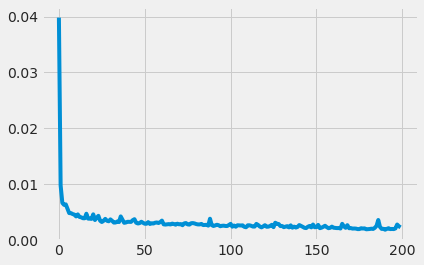

In [225]:
loss_values = history.history['loss']
plt.plot(loss_values)
sc = MinMaxScaler(feature_range=(0,1))
y_pred = model.predict(X)
y_test = sc.fit_transform(pd.DataFrame(data_set["TargetNextClose"][10:]))
y_pred = sc.inverse_transform(y_pred)
y_test = sc.inverse_transform(y_test)
def plot_result():
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df.index, y=y_test.ravel(), name='original', line=dict(color='green')))
    fig.add_trace(go.Scatter(x=df.index, y=y_pred.ravel(), name='prediction', line=dict(color='#FF9E44')))
    fig.update_layout(title_text="Prediction", xaxis_rangeslider_visible=True)
    fig.show()
plot_result()
mse = mean_squared_error(y_test[519:], y_pred[519:]) #648*0.8
rmse = sqrt(mse)
mape = mean_absolute_percentage_error(y_test[519:], y_pred[519:])
r_score = r2_score(y_test[519:], y_pred[519:])

print(rmse, mape, r_score)

# Model save

In [226]:
model.save('EveGPT')

INFO:tensorflow:Assets written to: EveGPT/assets


INFO:tensorflow:Assets written to: EveGPT/assets
